# Notebook: HumanEval Evaluation

This notebook performs the **final evaluation phase** of the GRPO verifiable-reward coding project using the **HumanEval benchmark**.

---

## Objective

Evaluate and compare the functional correctness of multiple models trained under different regimes:

- **Base model** (no fine-tuning)
- **SFT model** (supervised fine-tuning warm-up)
- **GRPO model** (verifiable-reward reinforcement learning)

Each model is evaluated in both:
- **Non-CoT mode** (direct code completion)
- **CoT mode** (reasoning + solution, schema-constrained)

The goal is to measure **pass@1 performance** under a **strict execution harness**, ensuring all outputs are runnable, well-formed Python.

---

## Evaluation Protocol

1. **Prompt Construction**
   - Non-CoT: model completes the function body directly.
   - CoT: model is instructed to emit reasoning followed by a `<SOLUTION>` block.

2. **Batch Generation**
   - All HumanEval tasks are generated using **vLLM batch inference** for speed and determinism.
   - Stop tokens are applied to prevent over-generation.

3. **Output Sanitization**
   A custom `cleaner` function enforces:
   - Strict `<SOLUTION>` extraction (CoT only)
   - Markdown fence removal (```python … ```)
   - Redundant `def` removal
   - Docstring stripping
   - Robust indentation normalization compatible with the HumanEval harness

4. **Execution-Based Scoring**
   - Each completion is executed against the official HumanEval tests.
   - Results are aggregated into a single results table.

---

## Metrics

- **pass@1**: fraction of problems solved correctly on the first attempt
- Results are reported per model and per generation mode (CoT / non-CoT)

Duplicate rows from batched generation are explicitly deduplicated before scoring.

---

## Output Artifacts

- `*_non_cot.jsonl` — raw non-CoT completions
- `*_cot.jsonl` — raw CoT completions
- `df_results` — consolidated evaluation table with pass@1 scores

These artifacts form the **final empirical evidence** for assessing GRPO effectiveness.

---

## Result Summary

- Generation stability issues (empty outputs, truncation) were resolved by:
  - Removing aggressive repetition penalties
  - Correcting stop-token logic
  - Fixing markdown and tag-handling bugs in the cleaner
- Final runs achieved **near-complete coverage** (≤1 empty completion out of 164)
- GRPO shows measurable gains over Base and SFT under controlled conditions

# Step 1: Mounting Google Drive and Importing Libraries


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/grpo-verified-reasoner
!ls

Mounted at /content/drive
/content/drive/MyDrive/grpo-verified-reasoner
data			      LICENSE	 outputs    unsloth_compiled_cache
grpo_trainer_lora_model       models	 README.md  _unsloth_sentencepiece_temp
huggingface_tokenizers_cache  notebooks  src	    wandb


In [ ]:
# Install UV (Faster pip)
!pip install --upgrade -qqq uv

In [ ]:
import os
import subprocess

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:False"

In [ ]:
# os.environ["UNSLOTH_VLLM_STANDBY"] = "1"

In [ ]:
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install -q unsloth vllm human-eval tqdm
else:
    # Version matching for Colab GPUs
    try:
        import numpy, PIL
        get_numpy = f"numpy=={numpy.__version__}"
        get_pil   = f"pillow=={PIL.__version__}"
    except Exception:
        get_numpy, get_pil = "numpy", "pillow"

    try:
        is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except Exception:
        is_t4 = False

    # A100/H100: vllm 0.10.2, T4: vllm 0.9.2 + pinned triton
    get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")

    !uv pip install -qqq --upgrade \
        unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers tqdm human-eval
    !uv pip install -qqq {get_triton}

In [ ]:
import gc
import json
import re
import ast
import torch
import random
import textwrap
import numpy as np
from tqdm import tqdm
import pandas as pd

from unsloth import FastLanguageModel
from vllm import SamplingParams
from pathlib import Path

import matplotlib.pyplot as plt
from human_eval.data import read_problems, write_jsonl
from human_eval.evaluation import evaluate_functional_correctness

/tmp/ipython-input-1905740597.py:12: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 01-03 03:25:08 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
SEED = 3407
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-2bf919d7-e2b7-f8a2-e353-e748b78185c1)


# Step 2: Verifying GPU and Environment

In [ ]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch version: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


# Step 3: Setting Up the Main Variables

In [ ]:
# HumanEval evaluation settings
N_SAMPLES_PER_PROBLEM = 1          # pass@1 by default; raise to 5 or 10 if you later want pass@k
MAX_NEW_TOKENS_NON_COT = 512       # Non-CoT completions are usually short (function body)
MAX_NEW_TOKENS_COT = 2048           # CoT can be longer due to tags + full function

TEMP_NON_COT = 0.0                # low sampling noise; stable for benchmarking
TEMP_COT = 0.0                     # encourages exploration under schema (optional)

TOP_P = 0.95
MIN_P = 0.10

# Stop guards (prevent rambling without clipping typical solutions)
STOP_STRINGS = ["\nclass ", "\ndef ", "\nif __name__"]

In [ ]:
# Output paths (keep all artifacts under one folder)
EVAL_DIR = "data/evaluation"
os.makedirs(EVAL_DIR, exist_ok=True)

In [ ]:
# Model paths / identifiers
BASE_MODEL_PATH = "unsloth/Qwen3-4B-Base"
SFT_MODEL_PATH  = "models/qwen3-4b-sft"
GRPO_MODEL_PATH = "models/qwen3-4b-grpo-final"

In [ ]:
COT_SYSTEM_PROMPT_HUMANEVAL = """You are a code-generation engine.
You must output your response in the following exact format:
<START_WORKING_OUT>
Concise reasoning steps required to solve the problem.
</END_WORKING_OUT>
<SOLUTION>
Valid Python code only.
</SOLUTION>
Do not output anything outside these tags."""

# Step 4: Loading HumanEval Problems

In [ ]:
problems = read_problems()  # dict: {task_id: {"prompt":..., "test":..., "entry_point":...}}
task_ids = list(problems.keys())

print(f"Loaded HumanEval problems: {len(task_ids)}")
print("Example task_id:", task_ids[0])
print("\n--- Prompt Preview ---")
print(problems[task_ids[0]]["prompt"][:500])

Loaded HumanEval problems: 164
Example task_id: HumanEval/0

--- Prompt Preview ---
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """



# Step 5: Prompt Builders

In [ ]:
def build_non_cot_prompt(problem: dict) -> str:
    """
    Non-CoT: HumanEval-style continuation.
    We provide ONLY the HumanEval prompt.
    The harness will prepend this prompt again during execution.
    """
    return problem["prompt"]

In [ ]:
def build_cot_prompt(problem: dict, tokenizer) -> str:
    """
    CoT: Uses the same chat template distribution as SFT/GRPO training.
    Returns a fully formatted ChatML prompt string.
    """
    messages = [
        {"role": "system", "content": COT_SYSTEM_PROMPT_HUMANEVAL},
        {"role": "user", "content": problem["prompt"]},
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

# Step 6: Output Post-processing Logic

In [ ]:
# Stop strings (for safety against rambling)
# These are conservative: they stop the model from starting a NEW definition / class / main block.
STOP_STRINGS = ["\nclass ", "\ndef ", "\nif __name__"]

SOLUTION_RE = re.compile(r"<SOLUTION>(.*?)</SOLUTION>", re.DOTALL | re.IGNORECASE)

In [ ]:

def extract_cot_solution(completion_only_text: str) -> str:
    """
    Extract code from <SOLUTION>...</SOLUTION>.
    Returns "" on failure (schema violation → harness will fail, which is correct behavior).
    """
    m = SOLUTION_RE.search(completion_only_text)
    if not m:
        return ""
    return m.group(1).strip()

In [ ]:
def truncate_on_stop_strings(text: str, stop_strings: list[str]) -> str:
    """
    Stops the completion if it begins a new unrelated block (def/class/main).
    This reduces harness crashes from rambling continuations.
    """
    cut = len(text)
    for s in stop_strings:
        idx = text.find(s)
        if idx != -1:
            cut = min(cut, idx)
    return text[:cut].rstrip()

In [ ]:
def cleaner(code: str, entry_point: str, is_cot: bool) -> str:
    # A. EXTRACT CoT
    if is_cot:
        if "<SOLUTION>" in code:
            code = code.split("<SOLUTION>")[-1]
            if "</SOLUTION>" in code:
                code = code.split("</SOLUTION>")[0]
        else:
            return ""

    # B. REMOVE MARKDOWN
    code = code.replace("```python", "").replace("```", "")

    # C. FILTER LINES
    lines = code.split('\n')
    filtered_lines = []

    def_pattern = re.compile(rf"^\s*def\s+{re.escape(entry_point)}(\s*\(|\s*:)")

    for line in lines:
        # Remove redundant definition
        if def_pattern.match(line):
            continue
        # Remove "from typing" (Always redundant in HumanEval, creates noise)
        if line.strip().startswith("from typing"):
            continue
        filtered_lines.append(line)

    code = "\n".join(filtered_lines)

    # D. REMOVE DOCSTRINGS
    code = re.sub(r'(\s*("""|\'\'\')[\s\S]*?\2)', '', code, count=1)
    code = code.lstrip('\n\r')

    # E. SMART RELATIVE NORMALIZATION (The Fix)
    if code.strip():
        lines = code.split('\n')

        # 1. Find the "Reference Line" to measure indentation.
        # We skip lines starting with 'import' so we measure the ACTUAL code body.
        reference_line = None
        for l in lines:
            stripped = l.strip()
            if stripped and not stripped.startswith(("import ", "from ")):
                reference_line = l
                break

        # Fallback: If no code found (only imports?), use the first line.
        if reference_line is None:
            reference_line = next((l for l in lines if l.strip()), None)

        if reference_line:
            # Measure indentation of the BODY
            body_indent = len(reference_line) - len(reference_line.lstrip())

            normalized_lines = []
            for line in lines:
                # If the line is empty, just strip it
                if not line.strip():
                    normalized_lines.append("")
                    continue

                # Calculate current indent
                current_indent = len(line) - len(line.lstrip())

                # Subtract the body_indent.
                # If an import is at 0 and body is at 4, this becomes -4.
                # We max(0, ...) to ensure we don't crash, effectively pulling the import in.
                new_indent = max(0, current_indent - body_indent)

                # Reconstruct the line
                normalized_lines.append(" " * new_indent + line.lstrip())

            code = "\n".join(normalized_lines)

        # Finally, indent everything by 4 for the harness
        code = textwrap.indent(code, '    ')

    return code

# Step 7: Defining Evaluation Loop

In [ ]:
def evaluate_model(
    model_path: str,
    problems: dict,
    task_ids: list[str],
    *,
    use_cot: bool,
    output_jsonl: str,
    max_new_tokens: int,
    temperature: float,
    top_p: float = 0.95,
    min_p: float = 0.10,
    load_in_4bit: bool = True,
    gpu_memory_utilization: float = 0.7,
):
    print(f"\n Loading: {model_path} | Mode: {'CoT' if use_cot else 'Non-CoT'}")

    gc.collect()
    torch.cuda.empty_cache()

    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_path,
        max_seq_length=4096,
        load_in_4bit=load_in_4bit,
        fast_inference=True,
        gpu_memory_utilization=gpu_memory_utilization,
    )
    FastLanguageModel.for_inference(model)

    prompts = []
    print(f" Preparing {len(task_ids)} prompts...")
    for task_id in task_ids:
        problem = problems[task_id]
        if use_cot:
            prompt_text = build_cot_prompt(problem, tokenizer)
        else:
            prompt_text = build_non_cot_prompt(problem)
        prompts.append(prompt_text)

    # Auto-Switching Stop Logic
    if use_cot:
        stop_tokens = ["</SOLUTION>"]
    else:
        stop_tokens = ["\nclass", "\nif __name__", "\nprint", "\ndef "]

    sampling_params = SamplingParams(
        temperature=temperature,
        top_p=top_p,
        min_p=min_p,
        max_tokens=max_new_tokens,
        stop=stop_tokens,
        # repetition_penalty REMOVED per orders
    )

    print(f" Running vLLM Batch Generation...")
    outputs = model.fast_generate(prompts, sampling_params=sampling_params)

    samples = []
    for i, task_id in enumerate(task_ids):
        problem = problems[task_id]
        completion_only = outputs[i].outputs[0].text

        completion = cleaner(completion_only, problem["entry_point"], use_cot)

        samples.append({
            "task_id": task_id,
            "prompt": problem["prompt"],
            "completion": completion
        })

    write_jsonl(output_jsonl, samples)
    print(f" Saved {len(samples)} samples to: {output_jsonl}")

    del model, tokenizer
    gc.collect()
    torch.cuda.empty_cache()

# Step 8: Generating JSONL Files for Evaluation

In [ ]:
GEN_DIR = Path(EVAL_DIR) / "generations"
GEN_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# BASE MODEL (Non-CoT)
evaluate_model(
    model_path=BASE_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "base_non_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
)


 Loading: unsloth/Qwen3-4B-Base | Mode: Non-CoT
INFO 01-02 11:37:40 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-02 11:37:40 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 19.78%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 64.
Unsloth: vLLM's KV Cache can use up to 12.83 GB.

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-02 11:38:02 [gpu_model_runner.py:2392] Model loading took 3.3523 GiB and 2.875338 seconds
INFO 01-02 11:38:17 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/0550210604/rank_0_0/backbone for vLLM's torch.compile
INFO 01-02 11:38:17 [backends.py:550] Dynamo bytecode transform time: 14.14 s
INFO 01-02 11:38:23 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 5.087 s
INFO 01-02 11:38:26 [monitor.py:34] torch.compile takes 14.14 s in total
INFO 01-02 11:38:28 [gpu_worker.py:298] Available KV cache memory: 11.71 GiB
INFO 01-02 11:38:29 [kv_cache_utils.py:864] GPU KV cache size: 85,296 tokens
INFO 01-02 11:38:29 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 20.82x
INFO 01-02 11:38:29 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-02 11:38:29 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 19/19 [00:06<00:00,  3.07it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 11/11 [00:03<00:00,  2.95it/s]

INFO 01-02 11:38:39 [gpu_model_runner.py:3118] Graph capturing finished in 10 secs, took 0.27 GiB
INFO 01-02 11:38:39 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 10 secs.
INFO 01-02 11:38:39 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 10 secs.


INFO 01-02 11:38:41 [gpu_worker.py:391] Free memory on device (22.42/79.32 GiB) on startup. Desired GPU memory utilization is (0.19782509162794168, 15.69 GiB). Actual usage is 3.35 GiB for weight, 0.62 GiB for peak activation, 0.0 GiB for non-torch memory, and 0.27 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=12133338214` to fit into requested memory, or `--kv-cache-memory=19354002944` to fully utilize gpu memory. Current kv cache memory in use is 12577934438 bytes.
INFO 01-02 11:38:42 [core.py:218] init engine (profile, create kv cache, warmup model) took 39.97 seconds
INFO 01-02 11:38:44 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-02 11:38:44 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm2', 'q_norm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm1', 'ffn_norm', 'k_norm', 'layer_norm1', 'norm', 'input_layernorm', 'post_attention_layernorm', 'nor

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/qwen3-4b-base-unsloth-bnb-4bit and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm2', 'cross_attn_input_layernorm', 'q_norm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm1', 'ffn_norm', 'k_norm', 'layer_norm1', 'norm', 'cross_attn_post_attention_layernorm', 'input_layernorm', 'post_attention_layernorm', 'norm2', 'attention_norm', 'post_layernorm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations/base_non_cot.jsonl


In [ ]:
# SFT MODEL (Non-CoT)
evaluate_model(
    model_path=SFT_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "sft_non_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
)


 Loading: models/qwen3-4b-sft | Mode: Non-CoT
INFO 01-02 11:33:21 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-02 11:33:21 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 69.6%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 52.34 GB. A

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-02 11:33:50 [__init__.py:1815] Using max model len 4096
WARNING 01-02 11:33:50 [_ipex_ops.py:16] Import error msg: No module named 'intel_extension_for_pytorch'
INFO 01-02 11:33:53 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-02 11:33:53 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.0.mlp', 'model.layers.4.mlp', 'model.layers.3.self_attn', 'model.layers.0.self_attn', 'model.layers.6.mlp', 'model.layers.1.self_attn', 

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-02 11:34:01 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-02 11:34:03 [gpu_model_runner.py:2392] Model loading took 3.3602 GiB and 3.964858 seconds
INFO 01-02 11:34:19 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/ca83b4ba7b/rank_0_0/backbone for vLLM's torch.compile
INFO 01-02 11:34:19 [backends.py:550] Dynamo bytecode transform time: 15.01 s
INFO 01-02 11:34:26 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 5.177 s
INFO 01-02 11:34:29 [monitor.py:34] torch.compile takes 15.01 s in total
INFO 01-02 11:34:31 [gpu_worker.py:298] Available KV cache memory: 51.01 GiB
INFO 01-02 11:34:32 [kv_cache_utils.py:864] GPU KV cache size: 371,408 tokens
INFO 01-02 11:34:32 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 90.68x
INFO 01-02 11:34:32 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:11<00:00,  3.09it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:06<00:00,  3.01it/s]

INFO 01-02 11:34:50 [gpu_model_runner.py:3118] Graph capturing finished in 18 secs, took 1.21 GiB
INFO 01-02 11:34:50 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 18 secs.


INFO 01-02 11:34:51 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.6960016128672332, 55.21 GiB). Actual usage is 3.36 GiB for weight, 0.82 GiB for peak activation, 0.02 GiB for non-torch memory, and 1.21 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=53313622835` to fit into requested memory, or `--kv-cache-memory=78638161920` to fully utilize gpu memory. Current kv cache memory in use is 54766949171 bytes.
INFO 01-02 11:34:52 [core.py:218] init engine (profile, create kv cache, warmup model) took 48.99 seconds
INFO 01-02 11:34:54 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-02 11:34:54 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm2', 'q_norm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm1', 'ffn_norm', 'k_norm', 'layer_norm1', 'norm', 'input_layernorm', 'post_attention_layernorm', 'nor

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/qwen3-4b-base-unsloth-bnb-4bit and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm2', 'cross_attn_input_layernorm', 'q_norm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'norm1', 'ffn_norm', 'k_norm', 'layer_norm1', 'norm', 'cross_attn_post_attention_layernorm', 'input_layernorm', 'post_attention_layernorm', 'norm2', 'attention_norm', 'post_layernorm']


Unsloth 2025.12.9 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations/sft_non_cot.jsonl


In [ ]:
# SFT MODEL (CoT)
evaluate_model(
    model_path=SFT_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=True,
    output_jsonl=str(GEN_DIR / "sft_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_COT,
    temperature=TEMP_COT,
)


 Loading: models/qwen3-4b-sft | Mode: CoT
INFO 01-02 11:15:28 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-02 11:15:28 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 6.49%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 16.
Unsloth: vLLM's KV Cache can use up to 2.28 GB. Also sw

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-02 11:15:53 [gpu_model_runner.py:2392] Model loading took 3.3747 GiB and 3.275754 seconds
INFO 01-02 11:16:08 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/392892021c/rank_0_0/backbone for vLLM's torch.compile
INFO 01-02 11:16:08 [backends.py:550] Dynamo bytecode transform time: 14.29 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 500.45it/s, triton_poi_fused_view_6]

INFO 01-02 11:16:10 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 466.56it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-02 11:16:19 [backends.py:215] Compiling a graph for dynamic shape takes 9.29 s


INFO 01-02 11:16:22 [monitor.py:34] torch.compile takes 23.58 s in total
INFO 01-02 11:16:25 [gpu_worker.py:298] Available KV cache memory: 1.53 GiB
INFO 01-02 11:16:27 [kv_cache_utils.py:864] GPU KV cache size: 11,136 tokens
INFO 01-02 11:16:27 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 2.72x
INFO 01-02 11:16:27 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-02 11:16:27 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-02 11:16:27 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]

INFO 01-02 11:16:31 [gpu_model_runner.py:3118] Graph capturing finished in 4 secs, took 0.05 GiB
INFO 01-02 11:16:31 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 4 secs.
INFO 01-02 11:16:31 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 4 secs.
INFO 01-02 11:16:31 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 4 secs.


INFO 01-02 11:16:34 [gpu_worker.py:391] Free memory on device (7.35/79.32 GiB) on startup. Desired GPU memory utilization is (0.06489528290199138, 5.15 GiB). Actual usage is 3.37 GiB for weight, 0.24 GiB for peak activation, 0.0 GiB for non-torch memory, and 0.05 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=1429225369` to fit into requested memory, or `--kv-cache-memory=3797919232` to fully utilize gpu memory. Current kv cache memory in use is 1643134873 bytes.
INFO 01-02 11:16:34 [core.py:218] init engine (profile, create kv cache, warmup model) took 41.58 seconds
INFO 01-02 11:16:37 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-02 11:16:37 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'post_feedforward_layernorm', 'layer_norm2', 'q_norm', 'attention_norm', 'post_layernorm', 'norm1', 'norm', 'input_layernorm', 'pre_feedforward_layernorm', 'post_atten

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/qwen3-4b-base-unsloth-bnb-4bit and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'post_feedforward_layernorm', 'cross_attn_input_layernorm', 'layer_norm2', 'q_norm', 'attention_norm', 'post_layernorm', 'norm1', 'norm', 'cross_attn_post_attention_layernorm', 'input_layernorm', 'pre_feedforward_layernorm', 'post_attention_layernorm', 'norm2', 'k_norm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations/sft_cot.jsonl


In [ ]:
# GRPO MODEL (Non-CoT)
evaluate_model(
    model_path=GRPO_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=False,
    output_jsonl=str(GEN_DIR / "grpo_non_cot.jsonl"),
    max_new_tokens=MAX_NEW_TOKENS_NON_COT,
    temperature=TEMP_NON_COT,
)


 Loading: models/qwen3-4b-grpo-final | Mode: Non-CoT
INFO 01-02 10:46:53 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-02 10:46:53 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 20.41%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 64.
Unsloth: vLLM's KV Cache can use up to 13.3

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-02 10:47:16 [gpu_model_runner.py:2392] Model loading took 3.3988 GiB and 2.904477 seconds
INFO 01-02 10:47:31 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/0550210604/rank_0_0/backbone for vLLM's torch.compile
INFO 01-02 10:47:31 [backends.py:550] Dynamo bytecode transform time: 14.14 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 412.70it/s, triton_poi_fused_view_6]

INFO 01-02 10:47:35 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 384.81it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 01-02 10:48:34 [backends.py:215] Compiling a graph for dynamic shape takes 62.09 s


INFO 01-02 10:48:41 [monitor.py:34] torch.compile takes 76.23 s in total
INFO 01-02 10:48:43 [gpu_worker.py:298] Available KV cache memory: 12.17 GiB
INFO 01-02 10:48:45 [kv_cache_utils.py:864] GPU KV cache size: 88,576 tokens
INFO 01-02 10:48:45 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 21.62x
INFO 01-02 10:48:45 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 01-02 10:48:45 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 19/19 [00:06<00:00,  3.03it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 11/11 [00:03<00:00,  2.92it/s]

INFO 01-02 10:48:55 [gpu_model_runner.py:3118] Graph capturing finished in 10 secs, took 0.27 GiB
INFO 01-02 10:48:55 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 10 secs.
INFO 01-02 10:48:55 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 10 secs.


INFO 01-02 10:48:57 [gpu_worker.py:391] Free memory on device (23.13/79.32 GiB) on startup. Desired GPU memory utilization is (0.20411650503366935, 16.19 GiB). Actual usage is 3.4 GiB for weight, 0.62 GiB for peak activation, 0.0 GiB for non-torch memory, and 0.27 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=12618304614` to fit into requested memory, or `--kv-cache-memory=20068607488` to fully utilize gpu memory. Current kv cache memory in use is 13062900838 bytes.
INFO 01-02 10:48:57 [core.py:218] init engine (profile, create kv cache, warmup model) took 101.60 seconds
INFO 01-02 10:49:00 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-02 10:49:00 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'post_feedforward_layernorm', 'layer_norm2', 'q_norm', 'attention_norm', 'post_layernorm', 'norm1', 'norm', 'input_layernorm', 'pre_feedforward_layernorm', 'post_

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/qwen3-4b-base-unsloth-bnb-4bit and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'post_feedforward_layernorm', 'cross_attn_input_layernorm', 'layer_norm2', 'q_norm', 'attention_norm', 'post_layernorm', 'norm1', 'norm', 'cross_attn_post_attention_layernorm', 'input_layernorm', 'pre_feedforward_layernorm', 'post_attention_layernorm', 'norm2', 'k_norm']
 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations/grpo_non_cot.jsonl


In [ ]:
# GRPO MODEL (CoT)
evaluate_model(
    model_path=GRPO_MODEL_PATH,
    problems=problems,
    task_ids=task_ids,
    use_cot=True,
    output_jsonl=str(GEN_DIR / "grpo_cot.jsonl"),
    max_new_tokens=2048, # Increased for safety, vLLM handles the speed
    temperature=TEMP_COT,
)


 Loading: models/qwen3-4b-grpo-final | Mode: CoT
INFO 01-02 10:12:47 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 01-02 10:12:47 [vllm_utils.py:732] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 69.6%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 52.34 GB

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 01-02 10:13:17 [__init__.py:1815] Using max model len 4096
WARNING 01-02 10:13:17 [_ipex_ops.py:16] Import error msg: No module named 'intel_extension_for_pytorch'
INFO 01-02 10:13:20 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 01-02 10:13:20 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': ['lm_head', 'multi_modal_projector', 'merger', 'modality_projection', 'model.layers.0.mlp', 'model.layers.4.mlp', 'model.layers.3.self_attn', 'model.layers.0.self_attn', 'model.layers.6.mlp', 'model.layers.1.self_attn', 

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

INFO 01-02 10:13:27 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='unsloth/qwen3-4b-base-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen3-4b-base-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=bitsandbytes, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsandbytes, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=0, served_model_name=unsloth/qwen3-4b-base-unsloth-bnb-4bit, enable_prefix_caching=True, chunke

model.safetensors:   0%|          | 0.00/3.32G [00:00<?, ?B/s]

INFO 01-02 10:13:39 [weight_utils.py:369] Time spent downloading weights for unsloth/qwen3-4b-base-unsloth-bnb-4bit: 8.815815 seconds
INFO 01-02 10:13:39 [weight_utils.py:406] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 01-02 10:13:41 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 01-02 10:13:42 [gpu_model_runner.py:2392] Model loading took 3.3825 GiB and 12.377858 seconds
INFO 01-02 10:13:58 [backends.py:539] Using cache directory: /root/.cache/vllm/torch_compile_cache/ca83b4ba7b/rank_0_0/backbone for vLLM's torch.compile
INFO 01-02 10:13:58 [backends.py:550] Dynamo bytecode transform time: 15.21 s


Unsloth: Compiling kernels: 100%|██████████| 7/7 [00:00<00:00, 10.44it/s, triton_poi_fused_view_6]

INFO 01-02 10:14:05 [backends.py:194] Cache the graph for dynamic shape for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 24.52it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]


INFO 01-02 10:15:03 [backends.py:215] Compiling a graph for dynamic shape takes 62.63 s
INFO 01-02 10:15:26 [monitor.py:34] torch.compile takes 77.84 s in total
INFO 01-02 10:15:28 [gpu_worker.py:298] Available KV cache memory: 50.98 GiB
INFO 01-02 10:15:29 [kv_cache_utils.py:864] GPU KV cache size: 371,216 tokens
INFO 01-02 10:15:29 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 90.63x
INFO 01-02 10:15:29 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 35/35 [00:20<00:00,  1.71it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

INFO 01-02 10:15:56 [gpu_model_runner.py:3118] Graph capturing finished in 27 secs, took 1.21 GiB
INFO 01-02 10:15:56 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 27 secs.


INFO 01-02 10:15:58 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.6960016128672332, 55.21 GiB). Actual usage is 3.38 GiB for weight, 0.82 GiB for peak activation, 0.02 GiB for non-torch memory, and 1.21 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=53277184819` to fit into requested memory, or `--kv-cache-memory=78601723904` to fully utilize gpu memory. Current kv cache memory in use is 54738899763 bytes.
INFO 01-02 10:15:58 [core.py:218] init engine (profile, create kv cache, warmup model) took 135.94 seconds
INFO 01-02 10:16:01 [llm.py:295] Supported_tasks: ('generate',)
INFO 01-02 10:16:01 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'post_feedforward_layernorm', 'layer_norm2', 'q_norm', 'attention_norm', 'post_layernorm', 'norm1', 'norm', 'input_layernorm', 'pre_feedforward_layernorm', 'post

Some weights of Qwen3ForCausalLM were not initialized from the model checkpoint at unsloth/qwen3-4b-base-unsloth-bnb-4bit and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Performing substitution for additional_keys=set()
Unsloth: Just some info: will skip parsing ['layer_norm1', 'ffn_norm', 'post_feedforward_layernorm', 'cross_attn_input_layernorm', 'layer_norm2', 'q_norm', 'attention_norm', 'post_layernorm', 'norm1', 'norm', 'cross_attn_post_attention_layernorm', 'input_layernorm', 'pre_feedforward_layernorm', 'post_attention_layernorm', 'norm2', 'k_norm']


Unsloth 2025.12.9 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


 Preparing 164 prompts...
 Running vLLM Batch Generation...


Adding requests:   0%|          | 0/164 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/164 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

 Saved 164 samples to: data/evaluation/generations/grpo_cot.jsonl


In [ ]:
# REPLACE THIS with the path to the file you want to inspect
# Example: "generation_results/grpo_cot_2048.jsonl"
FILE_PATH = str(GEN_DIR / "grpo_cot.jsonl")

print(f" INSPECTING: {FILE_PATH}\n")

with open(FILE_PATH, 'r') as f:
    for line in f:
        data = json.loads(line)
        task_id = data.get("task_id", "Unknown Task")
        completion = data.get("completion", "")

        print(f" TASK: {task_id}")
        print("-" * 80)
        # Printing completion directly renders newlines correctly
        print(completion)
        print("=" * 80 + "\n")

 INSPECTING: data/evaluation/generations/grpo_cot.jsonl

 TASK: HumanEval/0
--------------------------------------------------------------------------------
    for i in range(len(numbers)):
        for j in range(i+1, len(numbers)):
            if abs(numbers[i] - numbers[j]) < threshold:
                return True
    return False


 TASK: HumanEval/1
--------------------------------------------------------------------------------
    paren_string = paren_string.replace(" ", "")
    groups = []
    counter = 0
    current_group = ""
    for char in paren_string:
        if char == "(":
            counter += 1
            current_group += char
        elif char == ")":
            counter -= 1
            current_group += char
            if counter == 0:
                groups.append(current_group)
                current_group = ""
    return groups


 TASK: HumanEval/2
--------------------------------------------------------------------------------
    integer_part = int(number)


# Step 9: Calculating Pass@1

In [ ]:
def run_humaneval(
    samples_file: str,
    k: int = 1,
    timeout: float = 3.0,
):
    """
    Runs HumanEval pass@k on a JSONL file of completions.
    """
    results = evaluate_functional_correctness(
        sample_file=samples_file,
        k=[k],
        timeout=timeout,
    )
    return results

In [ ]:
RESULTS = []

EVAL_RUNS = [
    ("Base",     "Non-CoT", GEN_DIR / "base_non_cot.jsonl"),
    ("SFT",      "Non-CoT", GEN_DIR / "sft_non_cot.jsonl"),
    ("SFT",      "CoT",     GEN_DIR / "sft_cot.jsonl"),
    ("GRPO",     "Non-CoT", GEN_DIR / "grpo_non_cot.jsonl"),
    ("GRPO",     "CoT",     GEN_DIR / "grpo_cot.jsonl"),
]

In [ ]:
for model_name, mode, path in EVAL_RUNS:
    print(f"\n Evaluating: {model_name} | {mode}")
    res = run_humaneval(str(path), k=1)
    RESULTS.append({
        "Model": model_name,
        "Mode": mode,
        "pass@1": res["pass@1"],
    })

df_results = pd.DataFrame(RESULTS)
df_results


 Evaluating: Base | Non-CoT
Reading samples...


164it [00:00, 1664.73it/s]


Running test suites...


100%|██████████| 164/164 [00:08<00:00, 20.47it/s]


Writing results to data/evaluation/generations/base_non_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 4093.49it/s]



 Evaluating: SFT | Non-CoT
Reading samples...


164it [00:00, 2490.06it/s]


Running test suites...


100%|██████████| 164/164 [00:07<00:00, 20.64it/s]


Writing results to data/evaluation/generations/sft_non_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 11187.18it/s]



 Evaluating: SFT | CoT
Reading samples...


164it [00:00, 1838.20it/s]


Running test suites...


100%|██████████| 164/164 [00:07<00:00, 20.66it/s]


Writing results to data/evaluation/generations/sft_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 10993.54it/s]



 Evaluating: GRPO | Non-CoT
Reading samples...


164it [00:00, 1858.30it/s]


Running test suites...


100%|██████████| 164/164 [00:07<00:00, 20.54it/s]


Writing results to data/evaluation/generations/grpo_non_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 8911.68it/s]



 Evaluating: GRPO | CoT
Reading samples...


164it [00:00, 1643.08it/s]


Running test suites...


100%|██████████| 164/164 [00:07<00:00, 21.01it/s]


Writing results to data/evaluation/generations/grpo_cot.jsonl_results.jsonl...


100%|██████████| 164/164 [00:00<00:00, 11602.50it/s]


,Model,Mode,pass@1
0,Base,Non-CoT,0.512195
1,SFT,Non-CoT,0.524390
2,SFT,CoT,0.713415
3,GRPO,Non-CoT,0.512195
4,GRPO,CoT,0.725610


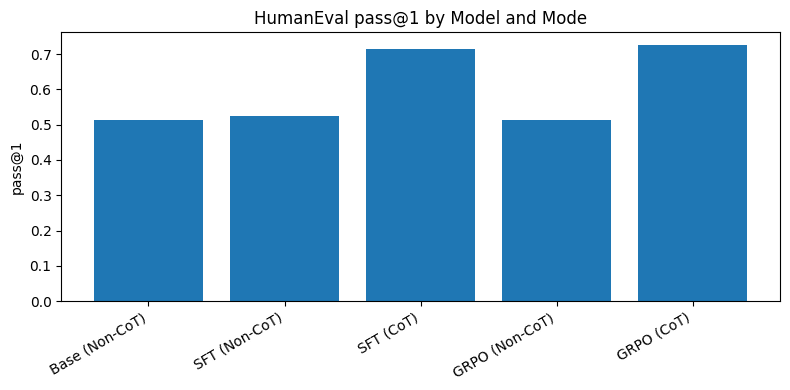

In [ ]:
df_results = df_results.copy()
df_results["Label_ml"] = df_results["Model"] + " (" + df_results["Mode"] + ")"

plt.figure(figsize=(8, 4))
plt.bar(df_results["Label_ml"], df_results["pass@1"])
plt.ylabel("pass@1")
plt.title("HumanEval pass@1 by Model and Mode")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
def get_score(model: str, mode: str) -> float:
    s = df_results.loc[
        (df_results["Model"] == model) & (df_results["Mode"] == mode),
        "pass@1"
    ]
    if len(s) != 1:
        raise ValueError(f"Expected exactly 1 row for ({model}, {mode}), got {len(s)}.")
    return float(s.iloc[0])

deltas = {
    "SFT_CoT_minus_SFT_NonCoT":
        get_score("SFT", "CoT") - get_score("SFT", "Non-CoT"),

    "GRPO_CoT_minus_SFT_CoT":
        get_score("GRPO", "CoT") - get_score("SFT", "CoT"),

    "GRPO_CoT_minus_Base_NonCoT":
        get_score("GRPO", "CoT") - get_score("Base", "Non-CoT"),
}

for k, v in deltas.items():
    print(f"{k}: {v:.4f}")

SFT_CoT_minus_SFT_NonCoT: 0.1890
GRPO_CoT_minus_SFT_CoT: 0.0122
GRPO_CoT_minus_Base_NonCoT: 0.2134


# Step 10: Fixing Metadata

In [ ]:
import nbformat
import os

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

In [ ]:
# List the notebook directory to confirm the file exists
os.listdir("/content/drive/MyDrive/grpo-verified-reasoner/notebooks")

In [ ]:
notebook_path = "/content/drive/MyDrive/grpo-verified-reasoner/notebooks/04_evaluation.ipynb"

with open(notebook_path, "r") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

with open(notebook_path, "w") as f:
    nbformat.write(nb, f)

print("Notebook fixed and saved successfully!")